In [ ]:
import torch
from utils import INPUT_DATA_DIR
import torchaudio
import json
from transformers import ClapModel, ClapProcessor
from typing import List, Dict

device = "cuda:1"
model_name = "laion/clap-htsat-fused"
max_tokens = 200
base_dir = INPUT_DATA_DIR / "music-bench" / "datashare-instruments"
model_sr = 32000

In [ ]:
processor = ClapProcessor.from_pretrained(model_name)
model = ClapModel.from_pretrained(model_name).to(device)
model.eval()

In [ ]:
with open(INPUT_DATA_DIR / "interp" / "features_grouped.json", "r") as fh:
    feat = json.load(fh)
with open(INPUT_DATA_DIR / "interp" / "final_descriptions.json", "r") as fh:
    desc = json.load(fh)

In [ ]:
def load_audio(base_dir, location, model_sr):
    audio_tensor, sr = torchaudio.load(str(base_dir / location).replace(".wav", ".mp3"))
    transform = torchaudio.transforms.Resample(sr, model_sr)
    return transform(audio_tensor).numpy()[0]


@torch.no_grad()
def embed_text(processor: ClapProcessor, model: ClapModel, text: str, device: torch.device):
    inputs = processor(text=[text], return_tensors="pt", padding=True).to(device)
    emb = model.get_text_features(**inputs)
    emb = emb / emb.norm(dim=-1, keepdim=True)
    return emb.squeeze(0).cpu()  # (D,)


@torch.no_grad()
def embed_audios(
    processor: ClapProcessor,
    model: ClapModel,
    audio_tensors: List[torch.Tensor],
    device: torch.device,
    batch_size: int,
):
    embs = []
    for i in range(0, len(audio_tensors), batch_size):
        batch = audio_tensors[i : i + batch_size]
        inputs = processor(audios=batch, sampling_rate=48_000, return_tensors="pt", padding=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        a_emb = model.get_audio_features(**inputs)
        a_emb = a_emb / a_emb.norm(dim=-1, keepdim=True)
        embs.append(a_emb.cpu())
    return torch.cat(embs, dim=0)


results: Dict[str, float] = {}
for key, details in desc.items():
    text_emb = embed_text(processor, model, details["overall_summary"], device)

    audios = [load_audio(base_dir, p, 32000) for p in feat[key]]
    audio_embs = embed_audios(processor, model, audios, device, 10)

    results[key] = (audio_embs @ text_emb).mean().item()

In [ ]:
with open(INPUT_DATA_DIR / "interp" / "features_ranked.json", "w") as fh:
    json.dump(results, fh, indent=4)
results

/tmp/ipykernel_2091250/1514737308.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="score", y="feature", data=top_k, palette="crest")


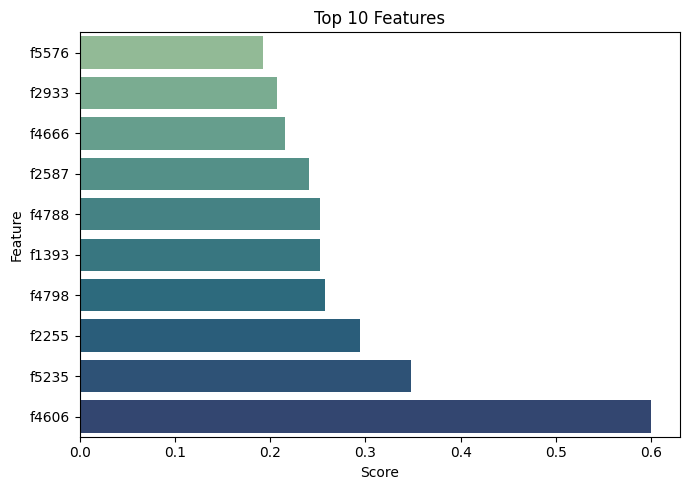

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def plot_top_k_features(feature_scores: dict, k: int = 10, by_abs: bool = False):
    """
    Plot a bar-chart of the top-k features.

    Parameters
    ----------
    feature_scores : dict
        Mapping of feature name → numeric score.
    k : int, default 10
        How many top features to display.
    by_abs : bool, default False
        If True, rank by |score| instead of raw score.
    """
    # --- tidy the data ------------------------------------------------------
    df = pd.Series(feature_scores, name="score").rename_axis("feature").reset_index()

    # order the rows
    order_col = df["score"].abs() if by_abs else df["score"]
    top_k = (
        df.loc[order_col.nlargest(k).index].sort_values("score")  # pick k best  # sort for nicer plotting
    )

    # --- plot ---------------------------------------------------------------
    plt.figure(figsize=(7, 0.4 * k + 1))  # auto-grow height
    sns.barplot(x="score", y="feature", data=top_k, palette="crest")
    plt.title(f"Top {k} Features" + (" (|score|)" if by_abs else ""))
    plt.xlabel("Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()


with open(INPUT_DATA_DIR / "interp" / "features_ranked.json", "r") as fh:
    scores = json.load(fh)
plot_top_k_features(scores)